# E-processes, Ville's Inequality, and Game-Theoretic Statistical Inference

This notebook illustrates some of the key concepts of game-theoretic statistical inference via e-processes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import comparecast as cc

In [2]:
cc.set_theme()

In [3]:
rng = np.random.default_rng(20221103)

## Setup: Bounded IID Data

Suppose $Y_1, \dotsc, Y_T$ are iid draws from $\mathrm{Beta}(\mu, 1-\mu)$, so that $Y_t \in [0,1]$ a.s. and $\mathbb{E}[Y_t] = \mu$ for all $t$.

Throughout the notebook, we set $\mu = 0.75$ (the theoretical results hold for any value of $\mu \in [0,1]$).

In [4]:
def make_beta(T, mu=0.75, init_mean=0.5):
    """Generate samples from Beta(mu, 1-mu), and 
    also pre-compute mean and variance estimates."""
    
    times = np.arange(1, T + 1)
    ys = rng.beta(mu, 1 - mu, size=T)
    
    sums = np.cumsum(ys)
    means = sums / times
    pred_means = means.copy()
    pred_means[1:], pred_means[0] = means[:-1], init_mean
    
    pred_vs = np.cumsum((ys - pred_means) ** 2)
    
    return pd.DataFrame({
        "t": times,
        "y": ys,
        "pred_m": pred_means,
        "pred_v": pred_vs,
    })

In [5]:
mu = 0.75  # true mean
T = 1000

data = make_beta(T, mu)
data

,t,y,pred_m,pred_v
0,1,0.833937,0.500000,0.111514
1,2,0.998792,0.833937,0.138691
2,3,0.896870,0.916364,0.139071
3,4,0.979419,0.909866,0.143909
4,5,0.688475,0.927254,0.200924
...,...,...,...,...
995,996,0.812954,0.751722,93.269458
996,997,0.068052,0.751784,93.736947
997,998,1.000000,0.751098,93.798899
998,999,0.930353,0.751347,93.830942


## Martingale #1: Universal Representation + aGRAPA

Consider the following game (see, e.g., [Shafer, 2021]()). 

**Game.** Skeptic starts with wealth $\mathcal{K}_0 = 1$. Reality announces $\mu \in [0,1]$. 

For rounds $t = 1, 2, \dotsc$:
1. Skeptic announces a bet $\lambda_t \in \left[ -\frac{1}{1-\mu}, \frac{1}{\mu}\right]$, or equivalently, a betting function $S_t(y) = 1 + \lambda_t(y - \mu)$.
2. Reality announces $y_t \in [0, 1]$.
3. Skeptic's wealth is updated by $\mathcal{K}_t = \mathcal{K}_{t-1} \cdot S_t(y_t)$.

If the betting function satisfies $\mathbb{E}_{y \sim P_\mu \mid \mathcal{G}_{t-1}}[S_t(y)] = 1$, which it does in this case, then Skeptic's wealth is expected to stay around 1, and thus cannot expect to make money in this game.
At each round $t$, the bet $\lambda_t$ controls the fraction of wealth invested in the difference $Y_t - \mu$.

The measure-theoretic translation of this Skeptic's wealth (which is not necessary) can be done as follows.
For each $m \in [0,1]$ and a predictable process $\lambda = (\lambda_t)_{t\geq0}$, define $\mathcal{K}_0^{(m)} = 1$ and
$$
\mathcal{K}_t^{(m)} = \prod_{i=1}^t \left( 1 + \lambda_i(Y_i - m) \right)
$$
for $t \geq 1$. 

Then, $\mathcal{K}_t^{(\mu)}$ is a martingale:
$$
\mathbb{E}_{t-1}[\mathcal{K}_t^{(\mu)}] = \mathcal{K}_{t-1}^{(\mu)} \cdot \mathbb{E}[1 + \lambda_t (Y_t - \mu)] = \mathcal{K}_{t-1}^{(\mu)} \cdot \left( 1 + \lambda_t (\mathbb{E}[Y_t] - \mu) \right) = \mathcal{K}_{t-1}^{(\mu)}.
$$
To see how to choose $\lambda$ optimally, see [Waudby-Smith and Ramdas (2022)]().

In [6]:
from confseq.betting_strategies import lambda_aKelly

def log_wealth_aKelly(ys, m):
    bets = lambda_aKelly(ys, m)
    return np.cumsum(np.log(1.0 + bets * (ys - m)))

## Test Martingale #2: an Exponential Mixture

_This is a one-sided bet!_

**Game.** Skeptic starts with wealth $\mathcal{K}_0 = 1$. 
Reality announces $\mu \in [0,1]$. 
Skeptic announces a bet $\lambda \in [0, 1]$.

For rounds $t = 1, 2, \dotsc$:
1. Skeptic announces a prediction $\hat\mu_{t-1} \in [0,1]$ for "hedging", as part of the betting function $S_t(y) = \exp\left\{ \lambda(y - \mu) - \psi_E(\lambda)(y - \hat\mu_{t-1})^2 \right\}$.
2. Reality announces $y_t \in [0, 1]$.
3. Skeptic's wealth is updated by $\mathcal{K}_t = \mathcal{K}_{t-1} \cdot S_t(y_t)$.

In addition to betting on $y_t-\mu$, the Skeptic is effectively announcing a _hedge_ proportional to $(y_t-\hat\mu_{t-1})^2$.

Here, $\psi_E(\lambda) = -\lambda - \log(1-\lambda)$ represents a "CGF-like" function of a centered Exponential distribution.
By [Fan et al. (2015)](), it follows that $\mathbb{E}_{y \sim P_\mu \mid \mathcal{G}_{t-1}}[S_t(y)] \leq 1$. This makes the resulting wealth process a _test supermartingale_.

An **e-process** for the null $H_0: \mu \leq m$ is given by $E_t(\lambda) = \mathcal{K}_t^{(m)}(\lambda)$.
This is because, under $H_0$,
$$
\mathcal{K}_t^{(m)}(\lambda) = \exp \left\{ \lambda \sum_{i=1}^t(Y_i - \mu + \mu - m) - \psi_E(\lambda)\sum_{i=1}^t (Y_i - \hat\mu_{i-1})^2 \right\} = \mathcal{K}_t^{(\mu)}(\lambda) \cdot \exp\left\{ \lambda t(\mu - m) \right\} \leq \mathcal{K}_t^{(\mu)}(\lambda),
$$
and $\mathcal{K}_t^{(\mu)}(\lambda)$ is always a test supermartingale ([Ramdas et al., 2020]()).


We can further extend this to a _mixture_ of bets, which is understood as the Skeptic splitting their initial capital into fractions and playing many parallel games.
This leads to the following capital process:
$$
\mathcal{K}_t^{(\mu)}(F) := \int_0^1 \mathcal{K}_t^{(\mu)}(\lambda) dF(\lambda) = \int_0^1 \exp\left\{ \lambda\sum_{i=1}^t(y_i - \mu) - \psi_E(\lambda)\sum_{i=1}^t(y_i - \hat\mu_{i-1})^2 \right\} dF(\lambda).
$$
If $F$ is the Gamma distribution, then the mixture process can be computed in closed-form (up to certain Gamma functions).

In [7]:
def log_wealth_cm(ys, m, pred_vs, c=1, alpha_opt=0.05, v_opt=100.0):
    sums = np.cumsum(ys - m)
    rho = v_opt / (
        2 * np.log(1 / alpha_opt) + np.log(1 + 2 * np.log(1 / alpha_opt))
    )
    return cc.gamma_exponential_log_mixture(
        sums,
        pred_vs,
        rho,
        c,
    )

## Comparison of Test Martingales #1 and #2

In [8]:
gap = 0.1
max_wealth = np.log(10**10)

dfs = []
for m in [mu, mu - gap, mu - 2*gap]:
    m = np.round(m, 2)
    # aGRAPA
    log_wealth = log_wealth_aKelly(data.y, m)
    dfs.append(pd.DataFrame({
        "t": data.t,
        "method": ["aGRAPA" for _ in range(T)],
        "m": [m for _ in range(T)],
        "wealth": np.exp(np.minimum(log_wealth, max_wealth)),
    }))
    # Gamma-Exponential Mixture
    log_wealth = log_wealth_cm(data.y, m, data.pred_v)
    dfs.append(pd.DataFrame({
        "t": data.t,
        "method": ["ConjMix" for _ in range(T)],
        "m": [m for _ in range(T)],
        "wealth": np.exp(np.minimum(log_wealth, max_wealth)),
    }))

wealth = pd.concat(dfs, axis=0, ignore_index=True)

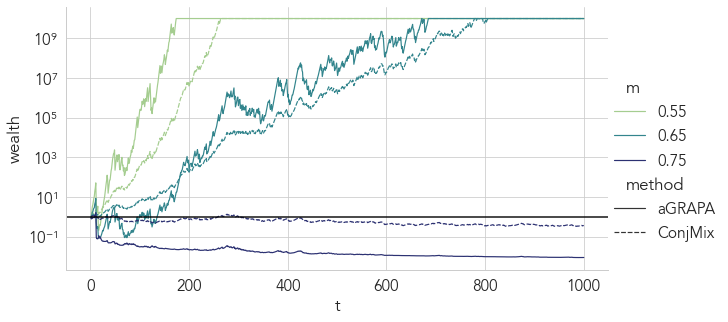

In [9]:
fg = sns.relplot(
    x="t",
    y="wealth",
    hue="m",
    style="method",
    kind="line",
    aspect=1.75,
    palette="crest",
    data=wealth,
)
fg.ax.set(yscale="log")
fg.ax.axhline(y=1, linewidth=2, color="black", alpha=0.7)
None

## The running-maximum is *NOT* an e-process, but it still satisfies Ville's inequality

Under $H_0: \mu \leq m$, the conjugate-mixture e-process $E_t = \mathcal{K}_t^{(m)}$ is expected to be at most 1 at arbitrary stopping times.

This is notably NOT true for the running-supremum process, $U_t = \sup_{i \leq t} E_t$, and in fact $\mathbb{E}_P[U_t] \to \infty$ for $P \in H_0$.

Nevertheless, it does satisfy an implication of Ville's inequality:
$$
P(\exists t \geq 1: U_t > 1/\alpha) \leq \alpha.
$$
This makes $\mathsf{p}_t = \min\{1/U_t, 1\}$ a p-process.

Here, we simulate data using $\mu = m$ (i.e., $H_0$ is true) many times, and monitor the behaviors of $E_t$, $U_t$, and $\mathsf{p}_t$.

In [10]:
m = 0.75
n_repeats = 100
T = 10000

### 1. aGRAPA E-process (Martingale) for $H_0: \mu = 0.75$

In [11]:
dfs = []
times = np.arange(1, T + 1)
for run_id in range(n_repeats):
    # Truth
    data = make_beta(T, mu=m)
    log_wealth = log_wealth_aKelly(data.y, m)
    wealth = np.exp(log_wealth)
    running_max = np.maximum.accumulate(wealth)
    dfs.append(pd.DataFrame({
        "t": times,
        "RunID": run_id,
        "E": wealth,
        "U": running_max,
        "P": np.minimum(1, 1 / running_max),
    }))

df = pd.concat(dfs, axis=0, ignore_index=True)
mdf = df.melt(
    id_vars=["t", "RunID"],
    value_vars=["E", "U", "P"],
    var_name="Process",
    value_name="Value",
)

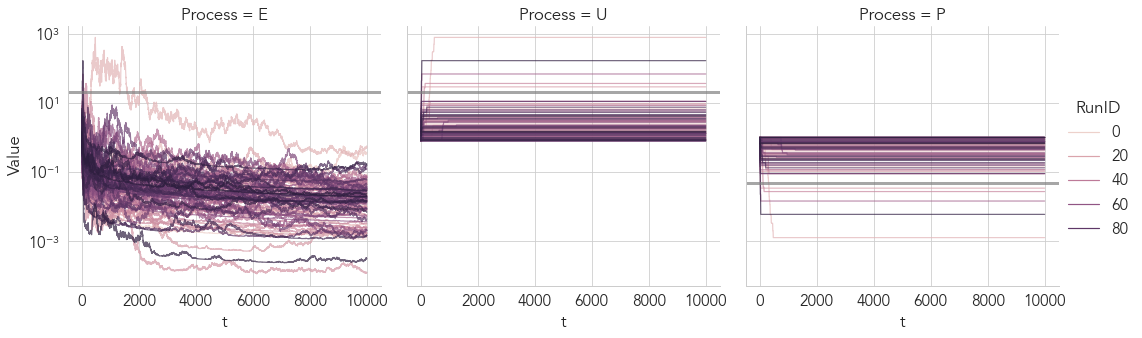

In [12]:
fg = sns.relplot(
    x="t",
    y="Value",
    hue="RunID",
    col="Process",
    kind="line",
    alpha=0.7,
    data=mdf,
)
fg.set(yscale="log")
# P <=? 0.05
fg.axes[0][0].axhline(y=1/0.05, color="gray", alpha=0.7, linewidth=3)
fg.axes[0][1].axhline(y=1/0.05, color="gray", alpha=0.7, linewidth=3)
fg.axes[0][2].axhline(y=0.05, color="gray", alpha=0.7, linewidth=3)
None

In [13]:
# Type I error control for the p-process at time T
(df[df.t == T].P <= 0.05).mean()

0.05

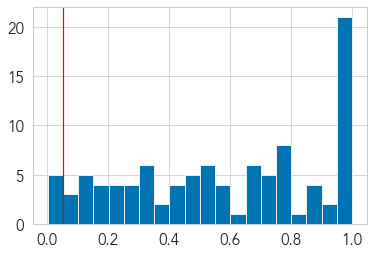

In [14]:
# stochastically >= Unif[0,1] ?
ax = df[df.t == T].P.hist(bins=20)
ax.axvline(x=0.05, color="red")
None

### 2. CM E-process (Supermartingale) for $H_0: \mu \leq 0.75$

In [15]:
dfs = []
times = np.arange(1, T + 1)
for run_id in range(n_repeats):
    # Truth
    data = make_beta(T, mu=m)
    log_wealth = log_wealth_cm(data.y, m, data.pred_v)
    wealth = np.exp(log_wealth)
    running_max = np.maximum.accumulate(wealth)
    dfs.append(pd.DataFrame({
        "t": times,
        "RunID": run_id,
        "E": wealth,
        "U": running_max,
        "P": np.minimum(1, 1 / running_max),
    }))

df = pd.concat(dfs, axis=0, ignore_index=True)
mdf = df.melt(
    id_vars=["t", "RunID"],
    value_vars=["E", "U", "P"],
    var_name="Process",
    value_name="Value",
)

In [16]:
# Type I error for the p-process at time T
(df[df.t == T].P <= 0.05).mean()

0.02

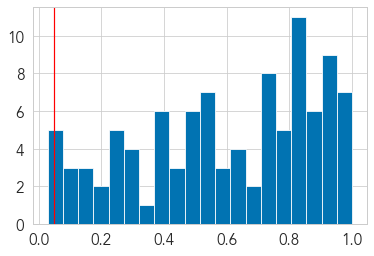

In [17]:
# stochastically >= Unif[0,1] ?
ax = df[df.t == T].P.hist(bins=20)
ax.axvline(x=0.05, color="red")
None

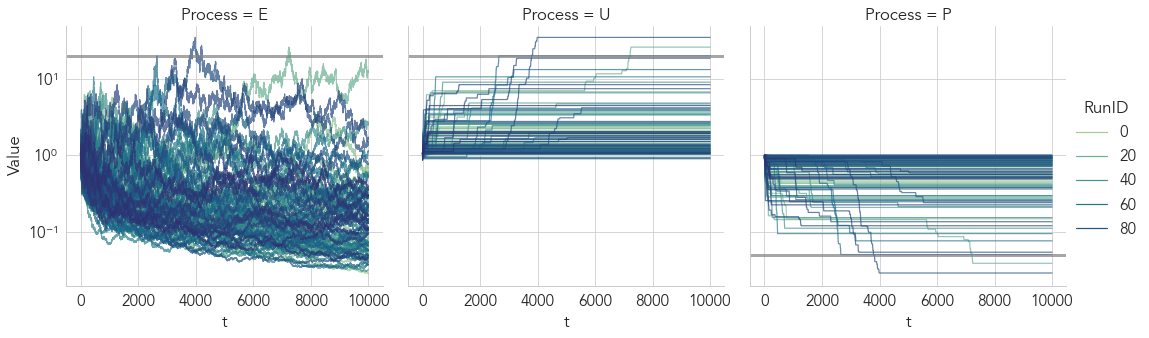

In [18]:
fg = sns.relplot(
    x="t",
    y="Value",
    hue="RunID",
    col="Process",
    kind="line",
    alpha=0.7,
    palette="crest",
    data=mdf,
)
fg.set(yscale="log")
# P <=? 0.05
fg.axes[0][0].axhline(y=1/0.05, color="gray", alpha=0.7, linewidth=3)
fg.axes[0][1].axhline(y=1/0.05, color="gray", alpha=0.7, linewidth=3)
fg.axes[0][2].axhline(y=0.05, color="gray", alpha=0.7, linewidth=3)
None

### 2'. CM E-process (Supermartingale) for $H_0: \mu \leq 0.75$ AND $H_0$ is false

In [19]:
mu = 0.765  # null is false!

dfs = []
times = np.arange(1, T + 1)
for run_id in range(n_repeats):
    # Truth
    data = make_beta(T, mu=mu)
    log_wealth = log_wealth_cm(data.y, m, data.pred_v)
    wealth = np.exp(log_wealth)
    running_max = np.maximum.accumulate(wealth)
    dfs.append(pd.DataFrame({
        "t": times,
        "RunID": run_id,
        "E": wealth,
        "U": running_max,
        "P": np.minimum(1, 1 / running_max),
    }))

df = pd.concat(dfs, axis=0, ignore_index=True)
mdf = df.melt(
    id_vars=["t", "RunID"],
    value_vars=["E", "U", "P"],
    var_name="Process",
    value_name="Value",
)

In [20]:
# Type II error for the p-process at time T
(df[df.t == T].P > 0.05).mean()

0.02

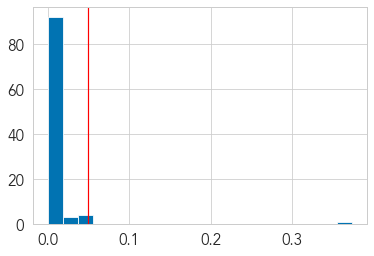

In [21]:
# all < alpha, if powerful
ax = df[df.t == T].P.hist(bins=20)
ax.axvline(x=0.05, color="red")
None

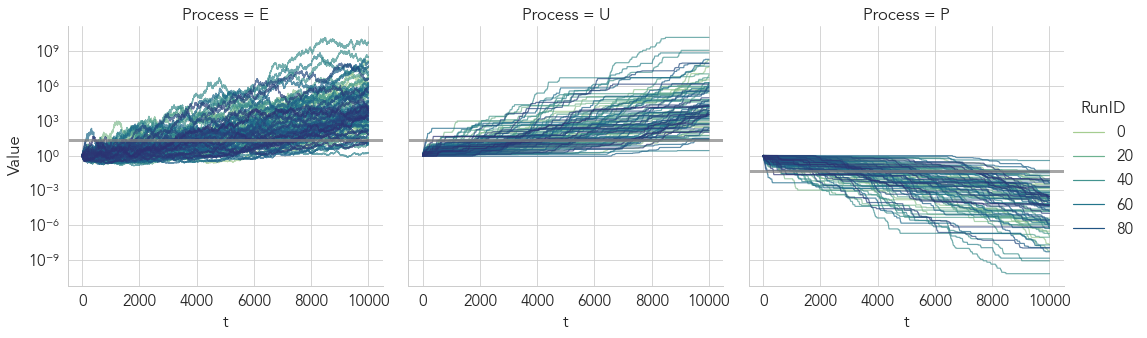

In [22]:
fg = sns.relplot(
    x="t",
    y="Value",
    hue="RunID",
    col="Process",
    kind="line",
    alpha=0.7,
    palette="crest",
    data=mdf,
)
fg.set(yscale="log")
# P <=? 0.05
fg.axes[0][0].axhline(y=1/0.05, color="gray", alpha=0.7, linewidth=3)
fg.axes[0][1].axhline(y=1/0.05, color="gray", alpha=0.7, linewidth=3)
fg.axes[0][2].axhline(y=0.05, color="gray", alpha=0.7, linewidth=3)
None